In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/MyDrive"

In [3]:
import datetime
import pandas as pd
import math
import tensorflow as tf
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import os

from tensorflow.python.client import device_lib
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

In [4]:
print(device_lib.list_local_devices())
print("===============")
print(torch.__version__)
print("===============")
print(torch.version.cuda)
print("===============")
print(torch.backends.cudnn.version())
print("===============")
print(tf.__version__)
print("===============")
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13317976972283293434
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20515454976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6006112742083745893
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22744530944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9788846526038661989
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6"
xla_global_id: 2144165316
]
2.1.2+cu121
12.1
8902
2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-12-28 14:39:53.113584: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 14:39:53.294628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 19565 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-12-28 14:39:53.295258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 21690 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [5]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# data preprocess

In [6]:
# filename = 'csv.tfrecords'

# raw_dataset = tf.data.TFRecordDataset(filename)
# X_train = []
# Y_train = []
# i=0
# for raw_record in raw_dataset:
#     sub_y = []
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)
#     # print(example.features.feature['icu_intime'].bytes_list)
#     # sub_y.append(0 if example.features.feature['gender'].float_list.value[0] == 0 else 1)
#     break

In [7]:
df  = pd.read_csv("final_result.csv")
print(df.head(5))

   Unnamed: 0  index   stay_id   hadm_id  subject_id  label  \
0           0      0  30039798  27880403    18499026      0   
1           1      0  30039798  27880403    18499026      0   
2           2      0  30039798  27880403    18499026      0   
3           3      0  30039798  27880403    18499026      0   
4           4      0  30039798  27880403    18499026      0   

            icu_intime  charttime  urineoutput          icu_outtime  \
0  2137-09-15 08:36:00          0          0.0  2137-09-16 17:28:21   
1  2137-09-15 08:36:00          1        185.0  2137-09-16 17:28:21   
2  2137-09-15 08:36:00          2         82.0  2137-09-16 17:28:21   
3  2137-09-15 08:36:00          3        220.0  2137-09-16 17:28:21   
4  2137-09-15 08:36:00          4        140.0  2137-09-16 17:28:21   

   aki_stage  aki_charttime  rank  
0        0.0              0     1  
1        0.0              1     1  
2        0.0              2     1  
3        0.0              3     1  
4        0.0  

In [7]:
# with tf.device('/cpu:0'):

#     filename = 'csv.tfrecords'
    
#     raw_dataset = tf.data.TFRecordDataset(filename)
#     # uo = data['urineoutput']
#     # aki_stage = data['aki_stage']
#     # charttime = data['charttime']
#     uo = []
#     aki_stage = []
#     charttime = []
#     stay_id_list = set()
#     i=0
#     for raw_record in raw_dataset:
#         sub_y = []
    
#         example = tf.train.Example()
#         example.ParseFromString(raw_record.numpy())
#         stay_id_list.add(example.features.feature['stay_id'].float_list.value[0])
#         # uo.append(example.features.feature['urineoutput'].float_list.value[0])
#         # aki_stage.append(example.features.feature['aki_stage'].float_list.value[0])
#         # charttime.append(example.features.feature['charttime'].float_list.value[0])
        
#     print(len(stay_id_list))
#     # print(len(uo))
#     # print(len(stay_id_list))
#     # X_train = np.array(X_train)
#     # Y_train = np.array(Y_train)
#     # X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],-1)
#     # Y_train = Y_train.astype(np.float64)
#     # print(Y_train.shape)



### padding data of each patient into the same length

In [8]:
stay_id_list = df["stay_id"].unique()
print("there are totally {} patients".format(len(stay_id_list)))

there are totally 49669 patients


In [9]:
# # Parameters for processing
# padding_hr = 23
# predict_after_hr = 6
# X_per_patient = []
# Y_per_patient = []

# # Process data for each stay_id
# for stay_id, data in stay_id_data.items():
#     uo = data['urineoutput']
#     aki_stage = data['aki_stage']
#     charttime = data['charttime']

#     if len(aki_stage) <= padding_hr + predict_after_hr:
#         continue

#     for i in range(len(aki_stage)):
#         if i + padding_hr > len(aki_stage) - 1:
#             break
#         aki_tmp = aki_stage[padding_hr + predict_after_hr]

#         uo_tmp = np.array(uo[i: i + padding_hr + 1])
#         time_tmp = np.array(charttime[i: i + padding_hr + 1])

#         uo_tmp = uo_tmp[:, np.newaxis]
#         time_tmp = time_tmp[:, np.newaxis]
#         x_tmp = np.hstack((uo_tmp, time_tmp))

#         X_per_patient.append(x_tmp)
#         Y_per_patient.append(aki_tmp)

# # Convert to NumPy arrays
# X_per_patient = np.array(X_per_patient, dtype=object)
# Y_per_patient = np.array(Y_per_patient, dtype=object)

# print("After processing, there are {} patients' data".format(len(X_per_patient)))
# print("X_per_patient shape:", X_per_patient.shape)
# print("Y_per_patient shape:", Y_per_patient.shape)

In [9]:
import numpy as np

padding_hr = 23
predict_after_hr = 6

X_per_patient = []  # urine output from 0H ~ (N - predict_after_hr)H
Y_per_patient = []  # AKI stage from (padding_hr + predict_after_hr)H ~ (N)H

for stay_id in stay_id_list:
    now_process = df.loc[df['stay_id'] == stay_id].reset_index()

    uo = now_process["urineoutput"].tolist()
    aki_stage = now_process["aki_stage"].tolist()
    charttime = now_process["charttime"].tolist()

    if len(aki_stage) <= padding_hr + predict_after_hr:  # there is not enough data for prediction
        continue

    # Convert AKI stages: Set any AKI stage not equal to 0 to 1
    aki_stage = [1 if stage != 0 else 0 for stage in aki_stage]

    # Sliding window, split each 24 hour as data
    for i in range(len(aki_stage) - padding_hr - predict_after_hr):
        aki_tmp = aki_stage[i + padding_hr + predict_after_hr]

        uo_tmp = np.array(uo[i: i + padding_hr + 1])
        time_tmp = np.array(charttime[i: i + padding_hr + 1])

        uo_tmp = uo_tmp[:, np.newaxis]
        time_tmp = time_tmp[:, np.newaxis]
        x_tmp = np.hstack((uo_tmp, time_tmp))

        X_per_patient.append(x_tmp)
        Y_per_patient.append(aki_tmp)

print("after process, there are {} patients' data".format(len(X_per_patient)))


X_per_patient = np.array(X_per_patient)
Y_per_patient = np.array(Y_per_patient)

# the (dim of X) should be the (dim of Y) - padding_hr
print(X_per_patient.shape)
print(Y_per_patient.shape)


after process, there are 2499542 patients' data
(2499542, 24, 2)
(2499542,)


In [10]:
Y_per_patient = Y_per_patient[:, np.newaxis, np.newaxis]
print(Y_per_patient.shape)

(2499542, 1, 1)


In [11]:
AKI_patient = 0
noAKI_patient = 0
for AKI_stages in Y_per_patient:
    if 1 in AKI_stages or 2 in AKI_stages or 3 in AKI_stages:
        AKI_patient += 1
    else:
        noAKI_patient += 1

print("therea are {} windows with AKI".format(AKI_patient))
print("therea are {} windows without AKI".format(noAKI_patient))

therea are 619198 windows with AKI
therea are 1880344 windows without AKI


### Split Data

In [12]:
def shuffle(X,Y):
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

X_per_patient, Y_per_patient = shuffle(X_per_patient, Y_per_patient)

In [13]:
def splitData(X, Y, val_rate, test_rate):
    X_val = X[ : int(X.shape[0]*val_rate)]
    Y_val = Y[ : int(Y.shape[0]*val_rate)]

    X_test = X[int(X.shape[0]*val_rate) : int(X.shape[0]*val_rate)+int(X.shape[0]*test_rate)]
    Y_test = Y[int(Y.shape[0]*val_rate) : int(Y.shape[0]*val_rate)+int(Y.shape[0]*test_rate)]

    X_train = X[int(X.shape[0]*val_rate)+int(X.shape[0]*test_rate) : ]
    Y_train = Y[int(Y.shape[0]*val_rate)+int(Y.shape[0]*test_rate) : ]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [14]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = splitData(X_per_patient, Y_per_patient, val_rate=0.2, test_rate=0.1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1749680, 24, 2)
(1749680, 1, 1)
(499908, 24, 2)
(499908, 1, 1)
(249954, 24, 2)
(249954, 1, 1)


# build LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.optimizers import Adam
from torch import nn
from torch.nn import functional as F
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend


In [ ]:
from keras.layers import Dropout
from keras.layers import Dense
import keras

def LSTMmodel():
    model = Sequential()
    model.add(LSTM(units=150, return_sequences = True, input_shape=((padding_hr + 1), 2)))
    model.add(Lambda(lambda x: x[:, -1:, :])) # use Lambda() to  remove output of the first `padding_hr` nodes
    #adding layer
    model.add(LSTM(units=150, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences = True))
    model.add(Dropout(0.2))
    # model.add(Dense(units = 1))

    model.add(TimeDistributed((Dense(2, activation='softmax'))))

    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #                 initial_learning_rate=1e-4,
    #                 decay_steps=14677,
    #                 decay_rate=0.9)

    # Compiling
    # regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    opt = Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=opt,\
                  loss='sparse_categorical_crossentropy',\
                  # accu 0.71 with 5 layers 
                  # loss='binary_crossentropy',\ #accu 0.35 with 10 layers 
                  # loss=keras.losses.BinaryCrossentropy(from_logits=True),\  accu = 0.05 with logits 1 to predict 0 and 1
                  metrics=['accuracy'])
    return model

LSTMmodel = LSTMmodel()
LSTMmodel.summary()
LSTMmodel.save_weights("checkpoint.weights.0.h5")

In [ ]:
import tensorflow as tf
import gc
# This approach would typically be implemented with a ReduceLROnPlateau callback rather than a LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
gc.collect()
tf.config.run_functions_eagerly(True)

EScallback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
CKPTcallback = ModelCheckpoint(filepath="ckpt/checkpoint.weights.{epoch}.h5", monitor='val_loss', \
                               verbose=1, save_best_only=True, save_weights_only=True, mode="auto")



# Reduce learning rate when a metric has stopped improving
RLcallback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Create a ReduceLROnPlateau callback
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor the validation loss
    factor=0.1,            # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001,         # Lower bound on the learning rate
    verbose=1              # Print messages when the callback takes an action
)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif lr > 5e-6:
      return lr * tf.math.exp(-0.1)
    else:
        return lr
LRcallback = LearningRateScheduler(scheduler)

LSTMmodel.load_weights("ckpt/checkpoint.weights.43.h5")

history_callback = LSTMmodel.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val), callbacks=[EScallback, CKPTcallback, reduce_lr_on_plateau])

/home/jupyter-luna10/.conda/envs/myenv_3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
14677/14677 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.7174
Epoch 1: val_loss improved from inf to 0.77243, saving model to ckpt/checkpoint.weights.1.h5
14677/14677 [==============================] - 553s 38ms/step - loss: 0.7679 - accuracy: 0.7174 - val_loss: 0.7724 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 2/100
14676/14677 [============================>.] - ETA: 0s - loss: 0.7682 - accuracy: 0.7175
Epoch 2: val_loss improved from 0.77243 to 0.77116, saving model to ckpt/checkpoint.weights.2.h5
14677/14677 [==============================] - 552s 38ms/step - loss: 0.7682 - accuracy: 0.7175 - val_loss: 0.7712 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 3/100
14677/14677 [==============================] - ETA: 0s - loss: 0.7688 - accuracy: 0.7172
Epoch 3: val_loss did not improve from 0.77116
14677/14677 [==============================] - 556s 38ms/step - loss: 0.7688 - accuracy: 0.7172 - val_loss: 0.7730 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


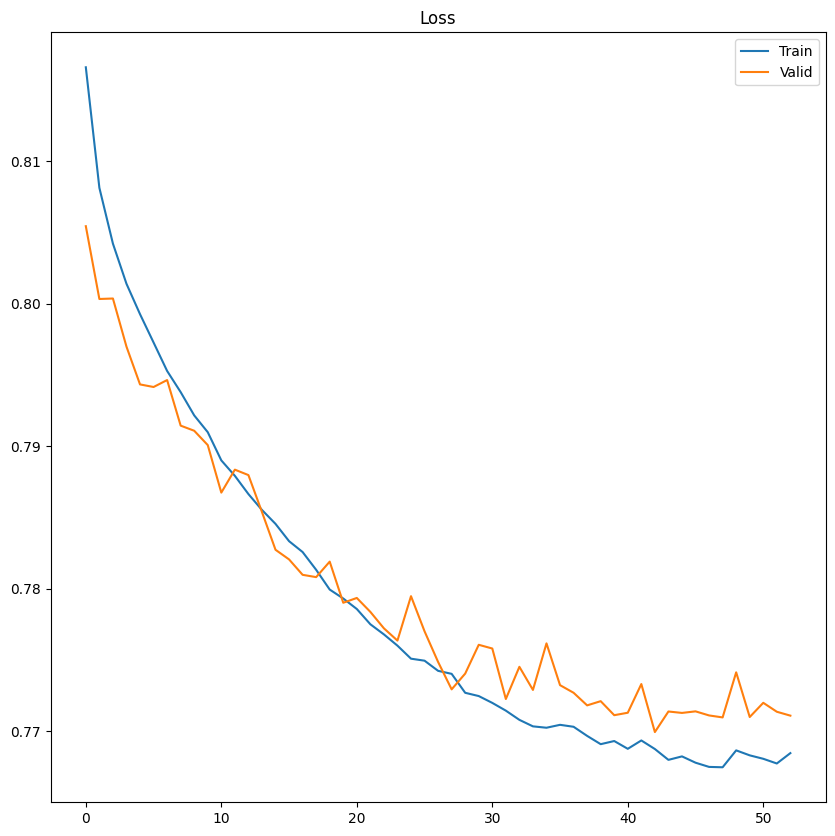

In [23]:
print(history_callback.history.keys())
total_epochs = len(history_callback.history["loss"])


fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
ax.set_title('Loss')
ax.plot(range(total_epochs), history_callback.history["loss"], label='Train')
ax.plot(range(total_epochs), history_callback.history["val_loss"], label='Valid')
ax.legend()
plt.show()
fig.savefig('metrics.jpg')
plt.close()

# try to evaluate by test set

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [17]:
# LSTMmodel.load_weights("ckpt/checkpoint.{}.weights.h5".format(121))
LSTMmodel.load_weights("checkpoint.weights.67.h5")
y_pred = LSTMmodel.predict(X_test)

y_pred_oneClass = np.argmax(y_pred, axis=2)
Y_test_2D = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

NameError: name 'LSTMmodel' is not defined

### all time accuracy (with -1 padding)

In [ ]:
### 5 classes
y_pred_flatten = y_pred_oneClass.reshape((-1))
y_test_flatten = Y_test_2D.reshape((-1))

print(classification_report(y_test_flatten, y_pred_flatten))
print(accuracy_score(y_test_flatten, y_pred_flatten))
print(confusion_matrix(y_test_flatten, y_pred_flatten))

print("=================")

### 3 classes
y_pred_flatten_3 = np.array(y_pred_flatten)
y_test_flatten_3 = np.array(y_test_flatten)

y_pred_flatten_3[y_pred_flatten_3 == 2] = 1
y_pred_flatten_3[y_pred_flatten_3 == 3] = 1
y_test_flatten_3[y_test_flatten_3 == 2] = 1
y_test_flatten_3[y_test_flatten_3 == 3] = 1

print(classification_report(y_test_flatten_3, y_pred_flatten_3))
print(accuracy_score(y_test_flatten_3, y_pred_flatten_3))
print(confusion_matrix(y_test_flatten_3, y_pred_flatten_3))


### without -1 padding

In [ ]:
### 5 classes
y_pred_nopad = []
y_test_nopad = []
for yp, yt in zip(y_pred_oneClass, Y_test_2D):
    yt_tmp = np.delete(yt, np.where(yt == 4))
    yp_tmp = yp[: yt_tmp.shape[0]]

    y_test_nopad = [*y_test_nopad, *yt_tmp]
    y_pred_nopad = [*y_pred_nopad, *yp_tmp]


print(classification_report(y_test_nopad, y_pred_nopad))
print(accuracy_score(y_test_nopad, y_pred_nopad))
print(confusion_matrix(y_test_nopad, y_pred_nopad))

print("=============")
### 3 classes
y_pred_nopad_3 = np.array(y_pred_nopad)
y_test_nopad_3 = np.array(y_test_nopad)

y_pred_nopad_3[y_pred_nopad_3 == 2] = 1
y_pred_nopad_3[y_pred_nopad_3 == 3] = 1
y_test_nopad_3[y_test_nopad_3 == 2] = 1
y_test_nopad_3[y_test_nopad_3 == 3] = 1

print(classification_report(y_test_nopad_3, y_pred_nopad_3))
print(accuracy_score(y_test_nopad_3, y_pred_nopad_3))
print(confusion_matrix(y_test_nopad_3, y_pred_nopad_3))

### without -1 padding, last 5 hours


In [ ]:
### 5 classes
y_pred_last5 = []
y_test_last5 = []
for yp, yt in zip(y_pred_oneClass, Y_test_2D):
    yt_tmp = np.delete(yt, np.where(yt == 4))
    yp_tmp = yp[: yt_tmp.shape[0]]

    y_test_last5 = [*y_test_last5, *yt_tmp[-5:]]
    y_pred_last5 = [*y_pred_last5, *yp_tmp[-5:]]


print(classification_report(y_test_last5, y_pred_last5))
print(accuracy_score(y_test_last5, y_pred_last5))
print(confusion_matrix(y_test_last5, y_pred_last5))

print("=============")
### 3 classes
y_pred_last5_3 = np.array(y_pred_last5)
y_test_last5_3 = np.array(y_test_last5)

y_pred_last5_3[y_pred_last5_3 == 2] = 1
y_pred_last5_3[y_pred_last5_3 == 3] = 1
y_test_last5_3[y_test_last5_3 == 2] = 1
y_test_last5_3[y_test_last5_3 == 3] = 1

print(classification_report(y_test_last5_3, y_pred_last5_3))
print(accuracy_score(y_test_last5_3, y_pred_last5_3))
print(confusion_matrix(y_test_last5_3, y_pred_last5_3))